In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
datas = {}
for i in glob.glob('../input/aaaaaa/*.csv'):
     datas[i.split('/')[-1].split('.')[0]] = pd.read_csv(i)

In [3]:
datas.keys()

dict_keys(['ETH-USD', 'SP500', 'EURUSD', 'nasdaq', 'BTC-USD'])

## Nasdaq and SP&500

In [4]:
data1 = datas['nasdaq'].copy()
data2 = datas['SP500'].copy()

In [5]:
data1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,4760.240234,4777.009766,4698.109863,4726.810059,4726.810059,1435150000
1,2015-01-05,4700.339844,4702.770020,4641.459961,4652.569824,4652.569824,1794470000
2,2015-01-06,4666.850098,4667.330078,4567.589844,4592.740234,4592.740234,2167320000
3,2015-01-07,4626.839844,4652.720215,4613.899902,4650.470215,4650.470215,1957950000
4,2015-01-08,4689.540039,4741.379883,4688.020020,4736.189941,4736.189941,2105450000


In [6]:
data2.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,206.380005,206.880005,204.179993,205.429993,179.784134,121465900
1,2015-01-05,204.169998,204.369995,201.350006,201.720001,176.537247,169632600
2,2015-01-06,202.089996,202.720001,198.860001,199.820007,174.874496,209151400
3,2015-01-07,201.419998,202.720001,200.880005,202.309998,177.053635,125346700
4,2015-01-08,204.009995,206.160004,203.990005,205.899994,180.195465,147217800


In [7]:
data1.Date = pd.DataFrame([datetime.datetime.strptime(i,'%Y-%m-%d') for i in data1.Date.values])
data2.Date = pd.DataFrame([datetime.datetime.strptime(i,'%Y-%m-%d') for i in data2.Date.values])

In [8]:
data1 = data1.set_index('Date')
data2 = data2.set_index('Date')

In [9]:
scaler1 = MinMaxScaler()
scaler1.fit_transform(data1)
data1_scaled = scaler1.transform(data1)
data1_scaled = pd.DataFrame(data1_scaled, columns = data1.columns)

scaler2 = MinMaxScaler()
scaler2.fit_transform(data2)
data2_scaled = scaler2.transform(data2)
data2_scaled = pd.DataFrame(data2_scaled, columns = data2.columns)

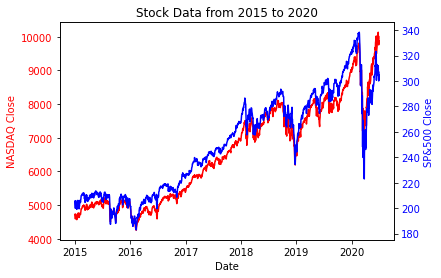

In [10]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('NASDAQ Close', color = 'red') 
ax1.plot(data1.Close, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 

ax2.set_ylabel('SP&500 Close', color = 'blue') 
ax2.plot(data2.Close, color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 

plt.title("Stock Data from 2015 to 2020")
plt.show()

In [11]:
X1 = []
y1 = []
for i in range(len(data1_scaled.Close.values)-5):
    X1.append(data1_scaled.Close.values[i:i+5])
    y1.append(data1_scaled.Close.values[i+5])
X1 = np.array(X1)
y1 = np.array(y1)

X2 = []
y2 = []
for i in range(len(data2_scaled.Close.values)-5):
    X2.append(data2_scaled.Close.values[i:i+5])
    y2.append(data2_scaled.Close.values[i+5])
X2 = np.array(X2)
y2 = np.array(y2)

In [12]:
len(X1)

1377

In [13]:
X1_train = X1[0:int(0.8*len(X1))]
X1_test = X1[int(0.8*len(X1)):]

X2_train = X2[0:int(0.8*len(X2))]
X2_test = X2[int(0.8*len(X2)):]

In [14]:
y1_train = y1[0:int(0.8*len(y1))]
y1_test = y1[int(0.8*len(y1)):]

y2_train = y2[0:int(0.8*len(y2))]
y2_test = y2[int(0.8*len(y2)):]

### Models

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from math import sqrt

In [16]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [17]:
models_used = [
    SVR(kernel='rbf', C=10),
    RandomForestRegressor(criterion='squared_error', n_estimators=500, max_depth=10, max_samples=12, max_leaf_nodes = 150),
    GradientBoostingRegressor(loss='squared_error', n_estimators=400, max_depth=5, max_leaf_nodes = 15, learning_rate = 0.1),
     MLPRegressor((9,), activation='logistic', learning_rate='adaptive', max_iter=500)
]

#### Data1

In [18]:
models_trained = []
scores = []
for model in tqdm.tqdm(models_used):
    model.fit(X1_train, y1_train.reshape(-1,1))
    y_predicted = model.predict(X1_train).reshape(-1,1)
    y_actual = y1_train
    
    rmse1 = sqrt(mean_squared_error(y_actual, y_predicted))
    mape1 = mean_absolute_percentage_error(y_actual, y_predicted)
    
    y_predicted = model.predict(X1_test).reshape(-1,1)
    y_actual = y1_test
    
    rms = sqrt(mean_squared_error(y_actual, y_predicted))
    map_ = mean_absolute_percentage_error(y_actual, y_predicted)
    
    models_trained.append(model)
    model_name = type(model).__name__
    scores.append((model_name,(f'{rmse1:.4f}'), (f'{rms:.2f}'), (f'{mape1:.4f}%'), (f'{map_:.4f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Training RMSE', 'Testing RMSE', 'Training MAPE', 'Testing MAPE'])

100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


In [19]:
scores_df

,Classifier,Training RMSE,Testing RMSE,Training MAPE,Testing MAPE
0,SVR,0.0423,0.29,54.6550%,28.5487%
1,RandomForestRegressor,0.0190,0.17,34.2951%,16.7597%
2,GradientBoostingRegressor,0.0022,0.14,1.0838%,12.0589%
3,MLPRegressor,0.0592,0.15,70.6897%,18.7470%


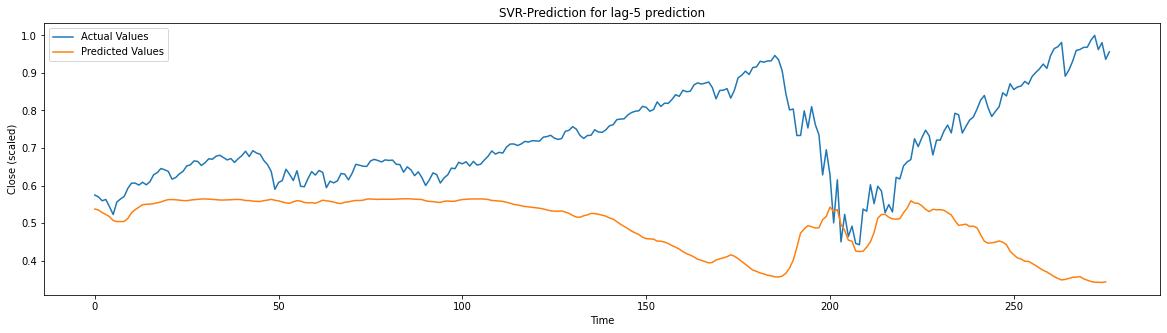

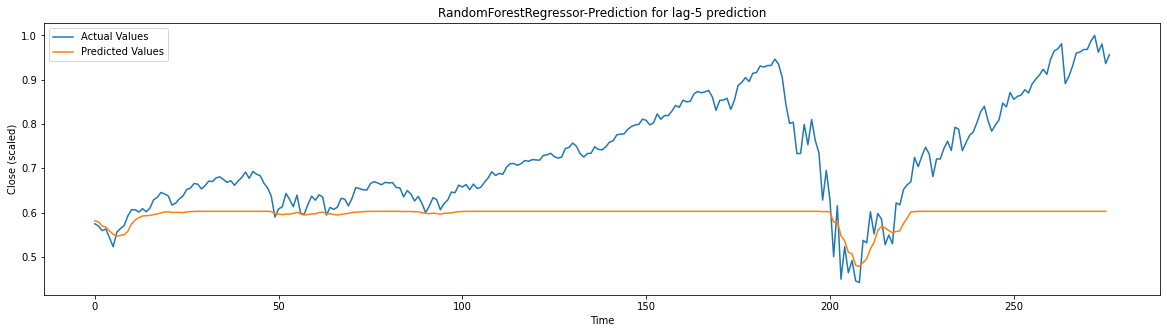

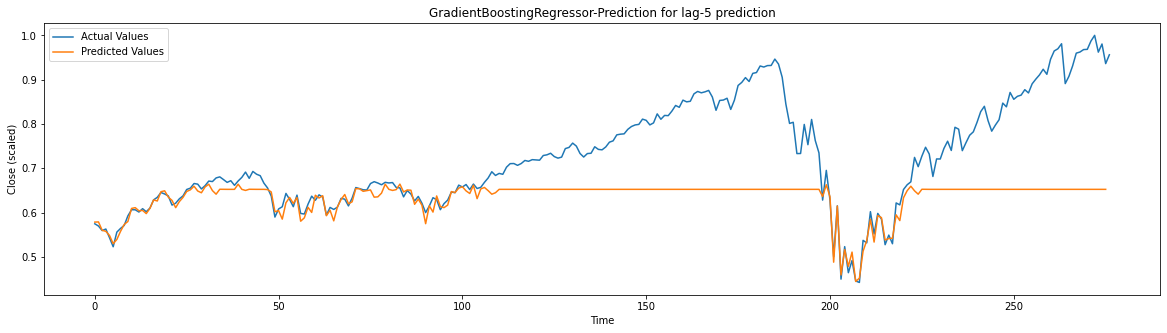

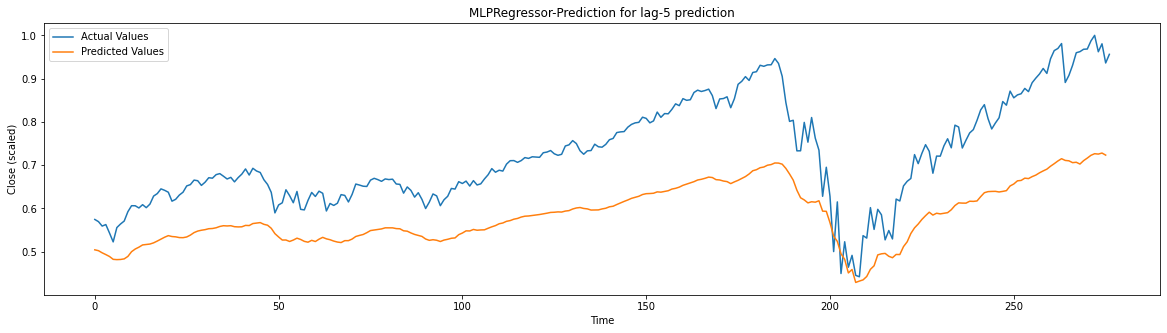

In [20]:
for i in models_trained:
    plt.figure(figsize=(20,5))
    plt.plot(data1_scaled.Close.values[int(0.8*len(data1_scaled.Close.values)):])
    plt.plot(i.predict(X1_test))
    plt.legend(['Actual Values', 'Predicted Values'])
    plt.title(f'{type(i).__name__}-Prediction for lag-5 prediction')
    plt.xlabel('Time')
    plt.ylabel('Close (scaled)')
    plt.show()

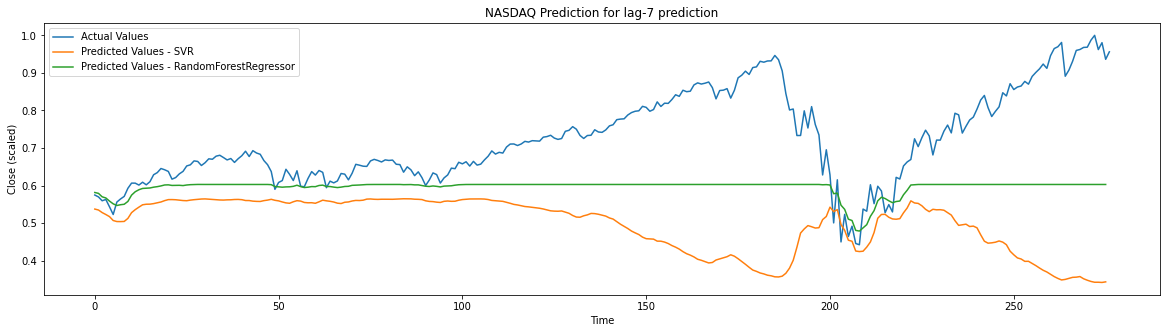

In [21]:
plt.figure(figsize=(20,5))
plt.plot(data1_scaled.Close.values[int(0.8*len(data1_scaled.Close.values)):])
plt.plot(models_trained[0].predict(X1_test))
plt.plot(models_trained[1].predict(X1_test))
plt.legend(['Actual Values', 'Predicted Values - SVR', 'Predicted Values - RandomForestRegressor'])
plt.title('NASDAQ Prediction for lag-7 prediction')
plt.xlabel('Time')
plt.ylabel('Close (scaled)')
plt.show()

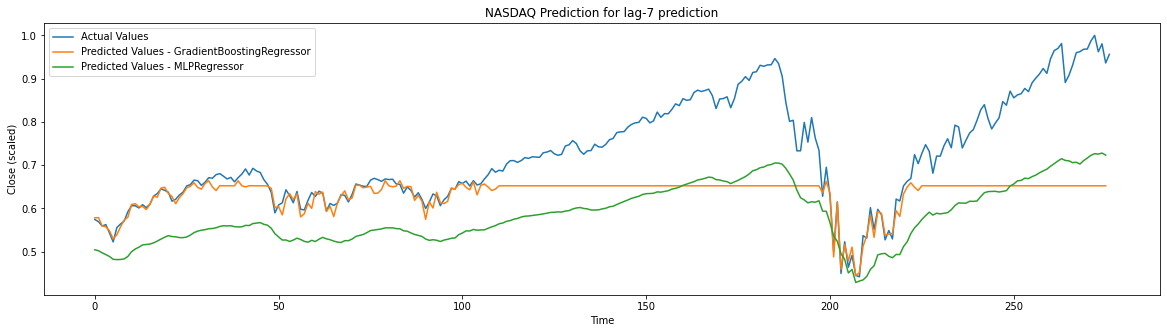

In [22]:
plt.figure(figsize=(20,5))
plt.plot(data1_scaled.Close.values[int(0.8*len(data1_scaled.Close.values)):])
plt.plot(models_trained[2].predict(X1_test))
plt.plot(models_trained[3].predict(X1_test))
plt.legend(['Actual Values', 'Predicted Values - GradientBoostingRegressor', 'Predicted Values - MLPRegressor'])
plt.title('NASDAQ Prediction for lag-7 prediction')
plt.xlabel('Time')
plt.ylabel('Close (scaled)')
plt.show()

#### Data2

In [23]:
models_used = [
    SVR(kernel='rbf', C=10),
    RandomForestRegressor(criterion='squared_error', n_estimators=500, max_depth=10, max_samples=12, max_leaf_nodes = 150),
    GradientBoostingRegressor(loss='squared_error', n_estimators=400, max_depth=5, max_leaf_nodes = 15, learning_rate = 0.1),
     MLPRegressor((9,), activation='logistic', learning_rate='adaptive', max_iter=500)
]

In [24]:
models_trained = []
scores = []
for model in tqdm.tqdm(models_used):
    model.fit(X2_train, y2_train.reshape(-1,1))
    y_predicted = model.predict(X2_train).reshape(-1,1)
    y_actual = y2_train
    
    rmse1 = sqrt(mean_squared_error(y_actual, y_predicted))
    mape1 = mean_absolute_percentage_error(y_actual, y_predicted)

    
    y_predicted = model.predict(X2_test).reshape(-1,1)
    y_actual = y2_test
    
    rms = sqrt(mean_squared_error(y_actual, y_predicted))
    map_ = mean_absolute_percentage_error(y_actual, y_predicted)

    models_trained.append(model)
    model_name = type(model).__name__
    scores.append((model_name,(f'{rmse1:.4f}'), (f'{rms:.2f}'), (f'{mape1:.4f}%'), (f'{map_:.4f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Training RMSE', 'Testing RMSE', 'Training MAPE', 'Testing MAPE'])

100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


In [25]:
scores_df

,Classifier,Training RMSE,Testing RMSE,Training MAPE,Testing MAPE
0,SVR,0.0376,0.26,13.5548%,25.7430%
1,RandomForestRegressor,0.0231,0.15,11.1645%,15.7224%
2,GradientBoostingRegressor,0.0026,0.12,0.8286%,11.6615%
3,MLPRegressor,0.0277,0.08,11.3169%,10.2505%


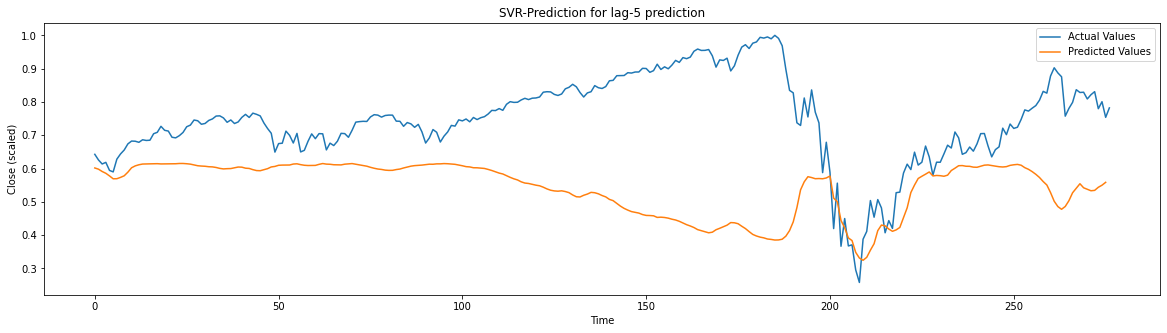

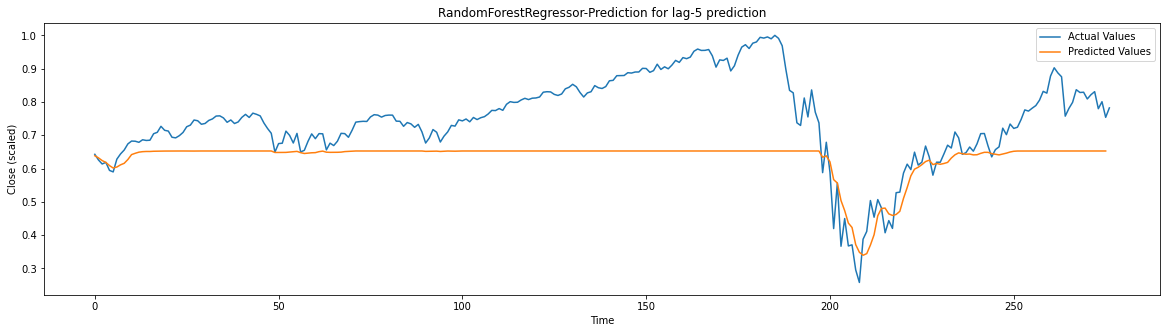

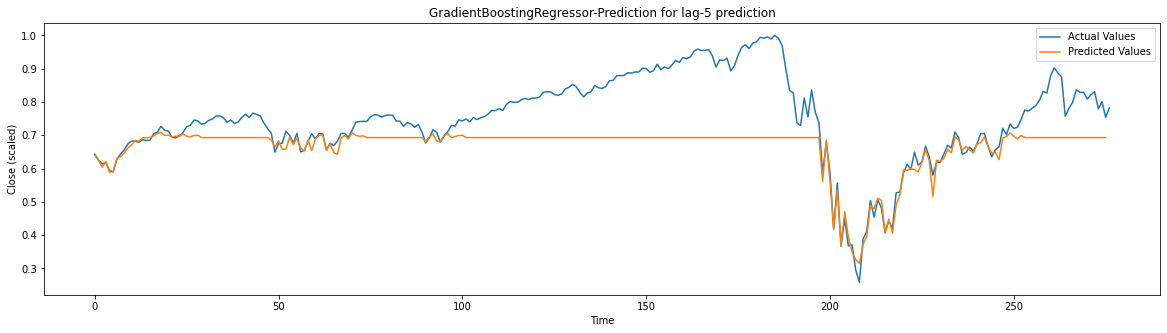

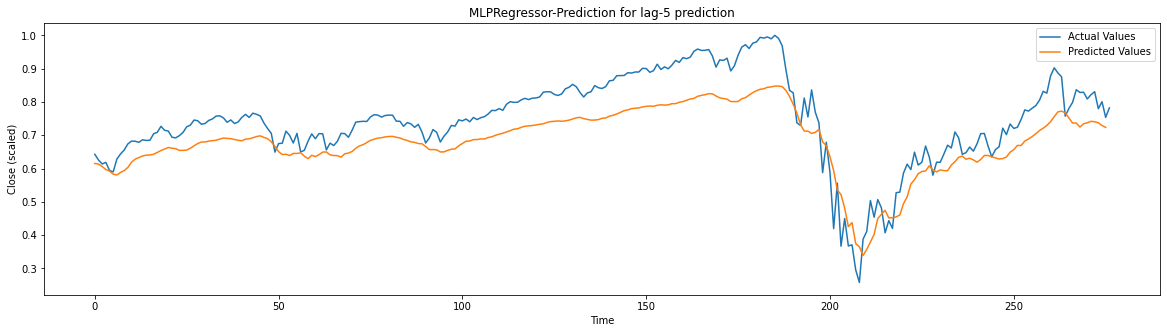

In [26]:
for i in models_trained:
    plt.figure(figsize=(20,5))
    plt.plot(data2_scaled.Close.values[int(0.8*len(data2_scaled.Close.values)):])
    plt.plot(i.predict(X2_test))
    plt.legend(['Actual Values', 'Predicted Values'])
    plt.title(f'{type(i).__name__}-Prediction for lag-5 prediction')
    plt.xlabel('Time')
    plt.ylabel('Close (scaled)')
    plt.show()

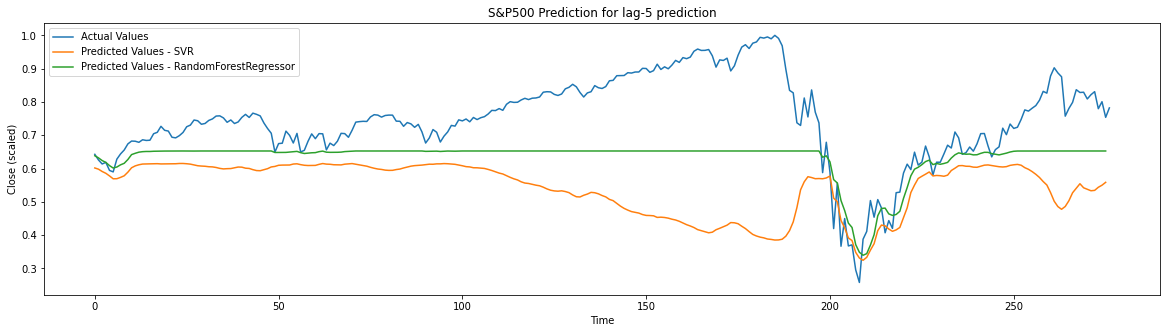

In [27]:
plt.figure(figsize=(20,5))
plt.plot(data2_scaled.Close.values[int(0.8*len(data2_scaled.Close.values)):])
plt.plot(models_trained[0].predict(X2_test))
plt.plot(models_trained[1].predict(X2_test))
plt.legend(['Actual Values', 'Predicted Values - SVR', 'Predicted Values - RandomForestRegressor'])
plt.title('S&P500 Prediction for lag-5 prediction')
plt.xlabel('Time')
plt.ylabel('Close (scaled)')
plt.show()

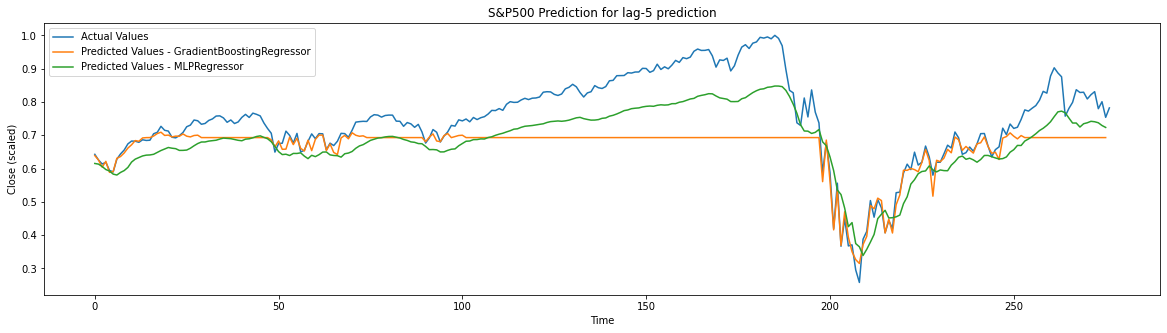

In [28]:
plt.figure(figsize=(20,5))
plt.plot(data2_scaled.Close.values[int(0.8*len(data2_scaled.Close.values)):])
plt.plot(models_trained[2].predict(X2_test))
plt.plot(models_trained[3].predict(X2_test))
plt.legend(['Actual Values', 'Predicted Values - GradientBoostingRegressor', 'Predicted Values - MLPRegressor'])
plt.title('S&P500 Prediction for lag-5 prediction')
plt.xlabel('Time')
plt.ylabel('Close (scaled)')
plt.show()

## EURUSD

In [29]:
data = datas['EURUSD'].copy()

In [30]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,1.209863,1.209863,1.209863,1.209863,1.209863,0.0
1,2015-01-02,1.208868,1.208956,1.201080,1.208941,1.208941,0.0
2,2015-01-05,1.195500,1.197590,1.188909,1.194643,1.194643,0.0
3,2015-01-06,1.193830,1.197000,1.188693,1.193902,1.193902,0.0
4,2015-01-07,1.187479,1.190000,1.180401,1.187536,1.187536,0.0


In [31]:
data.Date = pd.DataFrame([datetime.datetime.strptime(i,'%Y-%m-%d') for i in data.Date.values])

In [32]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,1.209863,1.209863,1.209863,1.209863,1.209863,0.0
1,2015-01-02,1.208868,1.208956,1.201080,1.208941,1.208941,0.0
2,2015-01-05,1.195500,1.197590,1.188909,1.194643,1.194643,0.0
3,2015-01-06,1.193830,1.197000,1.188693,1.193902,1.193902,0.0
4,2015-01-07,1.187479,1.190000,1.180401,1.187536,1.187536,0.0


In [33]:
data = data.set_index('Date')

In [34]:
scaler = MinMaxScaler()
scaler.fit_transform(data)
data_scaled = scaler.transform(data)
data_scaled = pd.DataFrame(data_scaled, columns = data.columns)

In [35]:
data_scaled = data_scaled.interpolate('nearest')

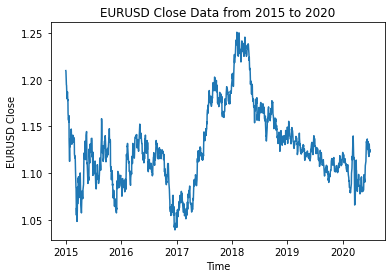

In [36]:
plt.plot(data.Close)
plt.xlabel('Time') 
plt.ylabel('EURUSD Close')
plt.title('EURUSD Close Data from 2015 to 2020')
plt.show()

In [37]:
X1 = []
y1 = []
for i in range(len(data_scaled.Close.values)-5):
    X1.append(data_scaled.Close.values[i:i+5])
    y1.append(data_scaled.Close.values[i+5])
X1 = np.array(X1)
y1 = np.array(y1)

In [38]:
print(len(X1), len(y1))

1429 1429


In [39]:
X1_train = X1[0:int(0.8*len(X1))]
X1_test = X1[int(0.8*len(X1)):]

In [40]:
y1_train = y1[0:int(0.8*len(y1))]
y1_test = y1[int(0.8*len(y1)):]

### Models

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from math import sqrt

In [42]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [43]:
models_used = [
    SVR(kernel='rbf', C=10),
    RandomForestRegressor(criterion='squared_error', n_estimators=500, max_depth=10, max_samples=12, max_leaf_nodes = 150),
    GradientBoostingRegressor(loss='squared_error', n_estimators=400, max_depth=5, max_leaf_nodes = 15, learning_rate = 0.1),
     MLPRegressor((9,), activation='logistic', learning_rate='adaptive', max_iter=500)
]

#### Data1

In [44]:
models_trained = []
scores = []
for model in tqdm.tqdm(models_used):
    model.fit(X1_train, y1_train.reshape(-1,1))
    y_predicted = model.predict(X1_train).reshape(-1,1)
    y_actual = y1_train
    
    rmse1 = sqrt(mean_squared_error(y_actual, y_predicted))
    mape1 = mean_absolute_percentage_error(y_actual, y_predicted)
    
    y_predicted = model.predict(X1_test).reshape(-1,1)
    y_actual = y1_test
    
    rms = sqrt(mean_squared_error(y_actual, y_predicted))
    map_ = mean_absolute_percentage_error(y_actual, y_predicted)
    
    models_trained.append(model)
    model_name = type(model).__name__
    scores.append((model_name,(f'{rmse1:.4f}'), (f'{rms:.2f}'), (f'{mape1:.4f}%'), (f'{map_:.4f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Training RMSE', 'Testing RMSE', 'Training MAPE', 'Testing MAPE'])

100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


In [45]:
scores_df

,Classifier,Training RMSE,Testing RMSE,Training MAPE,Testing MAPE
0,SVR,0.0398,0.03,15.9286%,6.2153%
1,RandomForestRegressor,0.0511,0.03,19.2952%,8.6347%
2,GradientBoostingRegressor,0.0068,0.03,1.6820%,6.6829%
3,MLPRegressor,0.1591,0.11,64.6608%,34.9864%


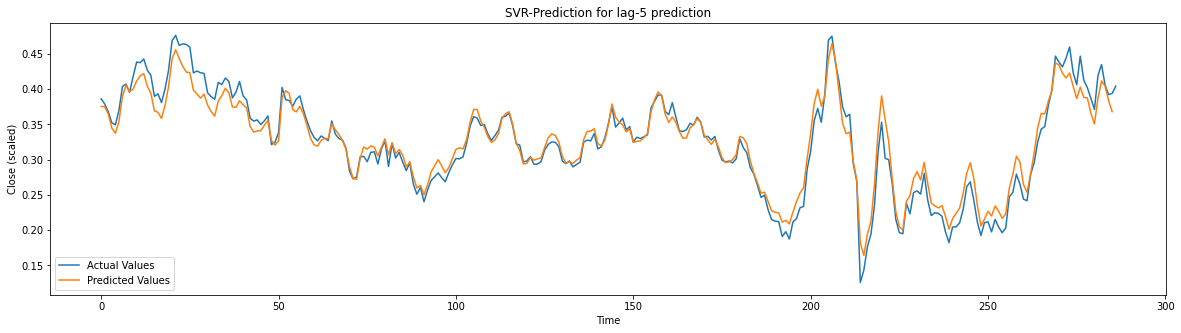

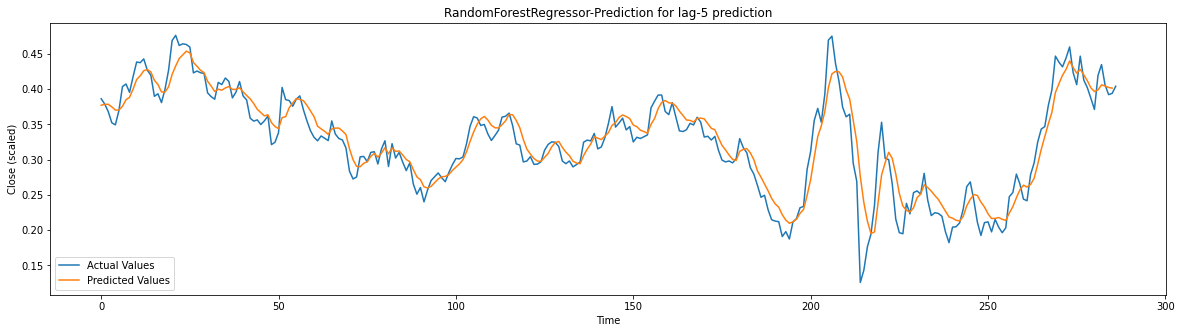

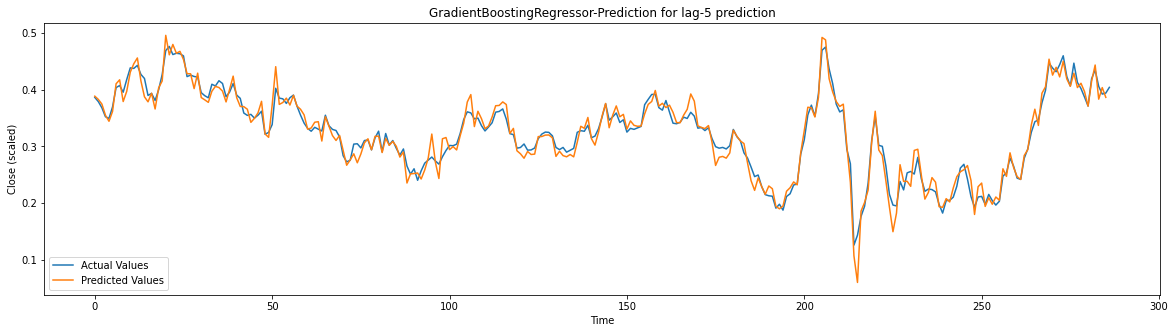

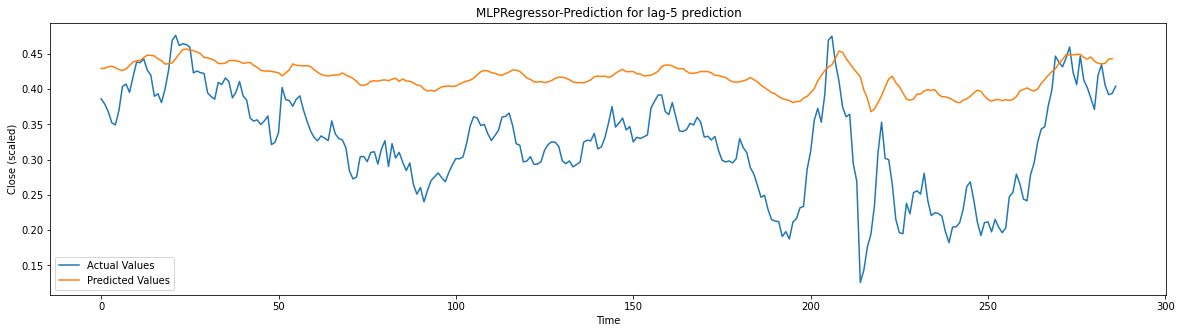

In [46]:
for i in models_trained:
    plt.figure(figsize=(20,5))
    plt.plot(data_scaled.Close.values[int(0.8*len(data_scaled.Close.values)):])
    plt.plot(i.predict(X1_test))
    plt.legend(['Actual Values', 'Predicted Values'])
    plt.title(f'{type(i).__name__}-Prediction for lag-5 prediction')
    plt.xlabel('Time')
    plt.ylabel('Close (scaled)')
    plt.show()

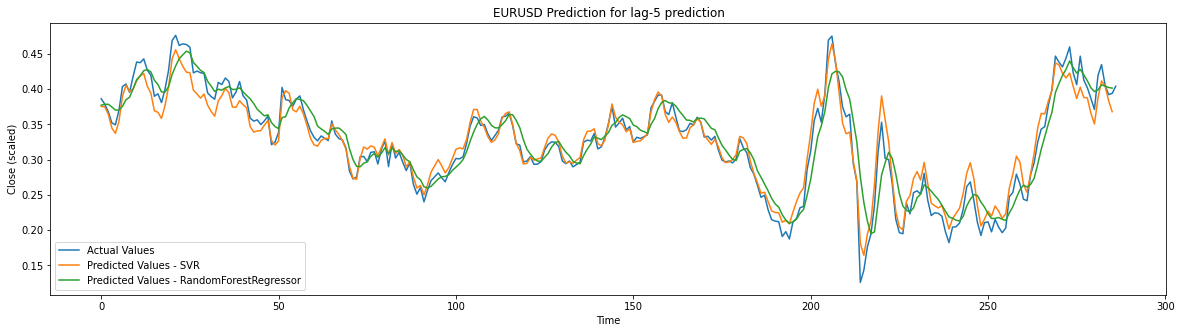

In [47]:
plt.figure(figsize=(20,5))
plt.plot(data_scaled.Close.values[int(0.8*len(data_scaled.Close.values)):])
plt.plot(models_trained[0].predict(X1_test))
plt.plot(models_trained[1].predict(X1_test))
plt.legend(['Actual Values', 'Predicted Values - SVR', 'Predicted Values - RandomForestRegressor'])
plt.title('EURUSD Prediction for lag-5 prediction')
plt.xlabel('Time')
plt.ylabel('Close (scaled)')
plt.show()

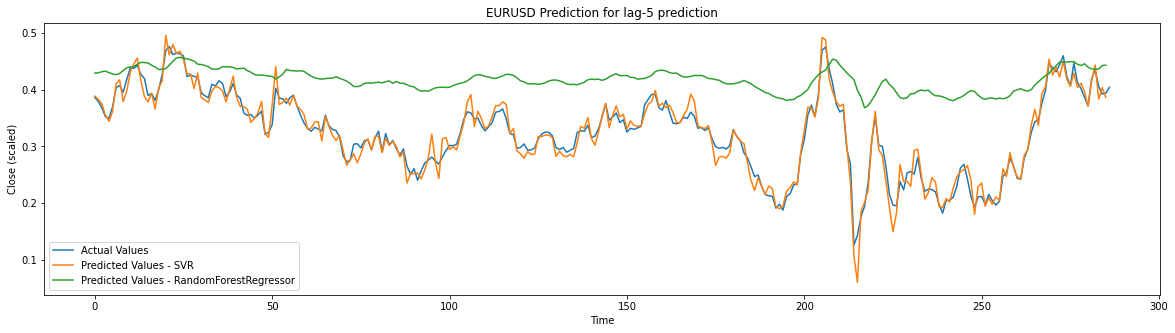

In [48]:
plt.figure(figsize=(20,5))
plt.plot(data_scaled.Close.values[int(0.8*len(data_scaled.Close.values)):])
plt.plot(models_trained[2].predict(X1_test))
plt.plot(models_trained[3].predict(X1_test))
plt.legend(['Actual Values', 'Predicted Values - SVR', 'Predicted Values - RandomForestRegressor'])
plt.title('EURUSD Prediction for lag-5 prediction')
plt.xlabel('Time')
plt.ylabel('Close (scaled)')
plt.show()

## BTC and ETH

In [49]:
data1 = datas['BTC-USD'].copy()
data2 = datas['ETH-USD'].copy()

In [50]:
data1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


In [51]:
data2.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [52]:
data1.Date = pd.DataFrame([datetime.datetime.strptime(i,'%Y-%m-%d') for i in data1.Date.values])
data2.Date = pd.DataFrame([datetime.datetime.strptime(i,'%Y-%m-%d') for i in data2.Date.values])

In [53]:
data1 = data1.set_index('Date')
data2 = data2.set_index('Date')

In [54]:
scaler1 = MinMaxScaler()
scaler1.fit_transform(data1)
data1_scaled = scaler1.transform(data1)
data1_scaled = pd.DataFrame(data1_scaled, columns = data1.columns)

scaler2 = MinMaxScaler()
scaler2.fit_transform(data2)
data2_scaled = scaler2.transform(data2)
data2_scaled = pd.DataFrame(data2_scaled, columns = data2.columns)

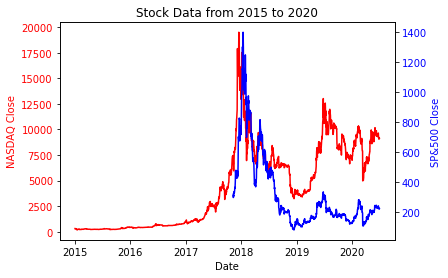

In [55]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('NASDAQ Close', color = 'red') 
ax1.plot(data1.Close, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 

ax2.set_ylabel('SP&500 Close', color = 'blue') 
ax2.plot(data2.Close, color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 

plt.title("Stock Data from 2015 to 2020")
plt.show()

In [56]:
X1 = []
y1 = []
for i in range(len(data1_scaled.Close.values)-7):
    X1.append(data1_scaled.Close.values[i:i+7])
    y1.append(data1_scaled.Close.values[i+7])
X1 = np.array(X1)
y1 = np.array(y1)

X2 = []
y2 = []
for i in range(len(data2_scaled.Close.values)-7):
    X2.append(data2_scaled.Close.values[i:i+7])
    y2.append(data2_scaled.Close.values[i+7])
X2 = np.array(X2)
y2 = np.array(y2)

In [57]:
X1_train = X1[0:int(0.8*len(X1))]
X1_test = X1[int(0.8*len(X1)):]

X2_train = X2[0:int(0.8*len(X2))]
X2_test = X2[int(0.8*len(X2)):]

In [58]:
y1_train = y1[0:int(0.8*len(y1))]
y1_test = y1[int(0.8*len(y1)):]

y2_train = y2[0:int(0.8*len(y2))]
y2_test = y2[int(0.8*len(y2)):]

### Models

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from math import sqrt

In [60]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [61]:
models_used = [
    SVR(kernel='rbf', C=10),
    RandomForestRegressor(criterion='squared_error', n_estimators=500, max_depth=10, max_samples=12, max_leaf_nodes = 150),
    GradientBoostingRegressor(loss='squared_error', n_estimators=400, max_depth=5, max_leaf_nodes = 15, learning_rate = 0.1),
     MLPRegressor((14,), activation='logistic', learning_rate='adaptive', max_iter=500)
]

#### Data1

In [62]:
models_trained = []
scores = []
for model in tqdm.tqdm(models_used):
    model.fit(X1_train, y1_train.reshape(-1,1))
    y_predicted = model.predict(X1_train).reshape(-1,1)
    y_actual = y1_train
    
    rmse1 = sqrt(mean_squared_error(y_actual, y_predicted))
    mape1 = mean_absolute_percentage_error(y_actual, y_predicted)
    
    y_predicted = model.predict(X1_test).reshape(-1,1)
    y_actual = y1_test
    
    rms = sqrt(mean_squared_error(y_actual, y_predicted))
    map_ = mean_absolute_percentage_error(y_actual, y_predicted)
    
    models_trained.append(model)
    model_name = type(model).__name__
    scores.append((model_name,(f'{rmse1:.4f}'), (f'{rms:.2f}'), (f'{mape1:.4f}%'), (f'{map_:.4f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Training RMSE', 'Testing RMSE', 'Training MAPE', 'Testing MAPE'])

100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


In [63]:
scores_df

,Classifier,Training RMSE,Testing RMSE,Training MAPE,Testing MAPE
0,SVR,0.0666,0.04,698.4776%,7.7749%
1,RandomForestRegressor,0.0521,0.06,13.3771%,9.9869%
2,GradientBoostingRegressor,0.0011,0.02,2.2372%,3.5020%
3,MLPRegressor,0.0261,0.03,46.3576%,5.1037%


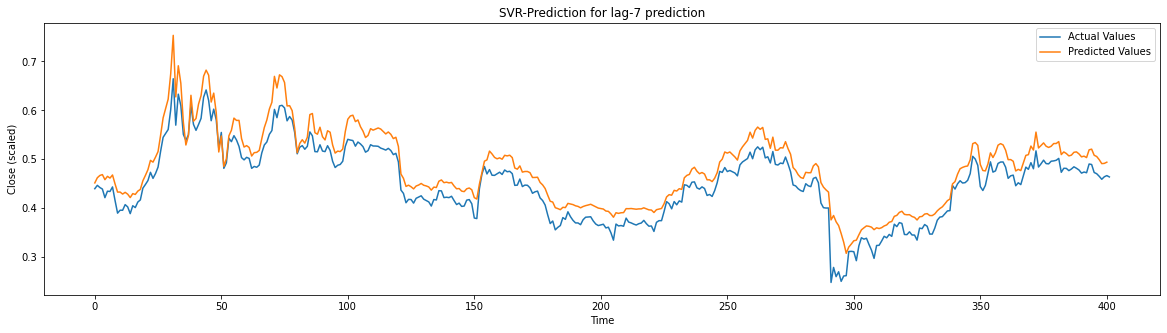

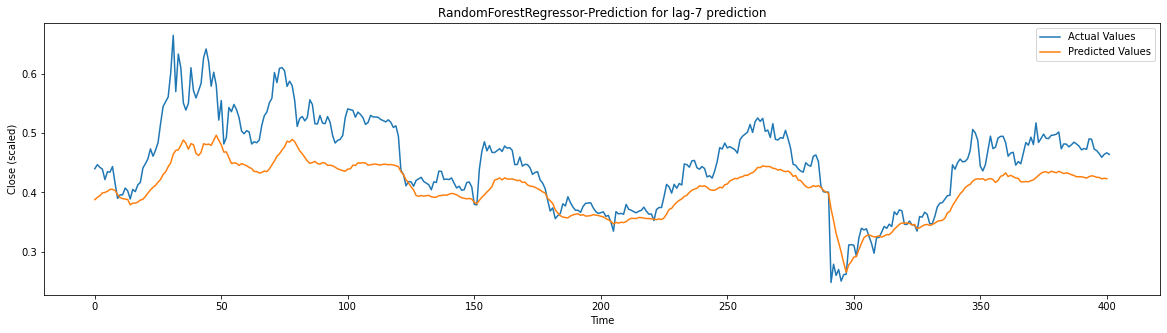

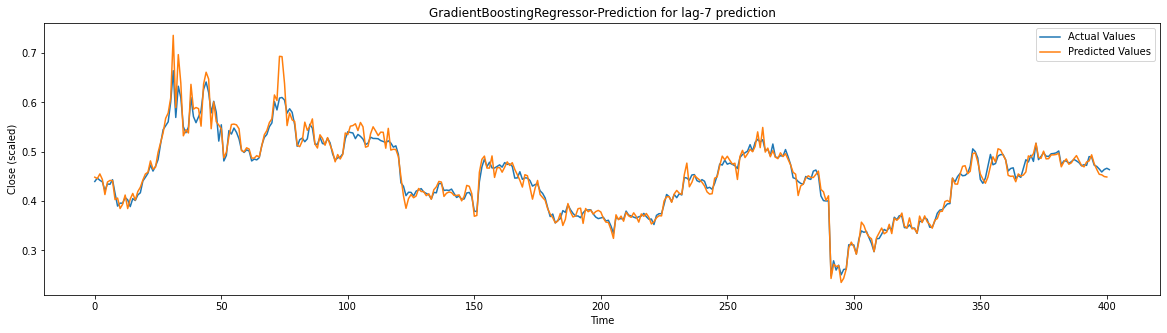

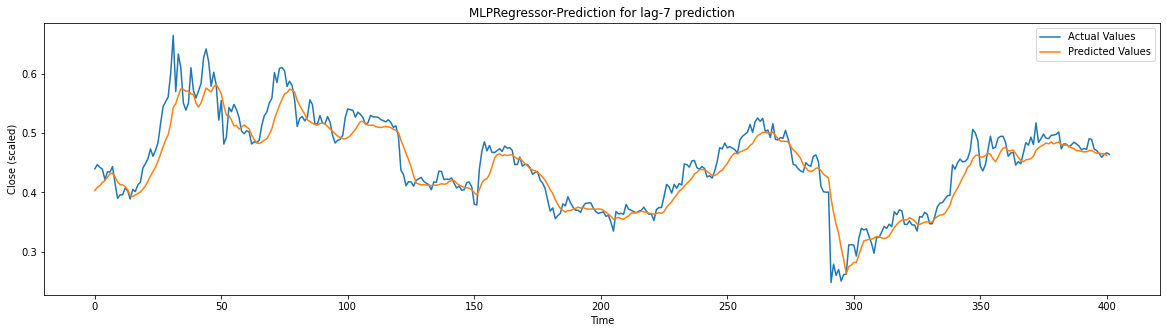

In [64]:
for i in models_trained:
    plt.figure(figsize=(20,5))
    plt.plot(data1_scaled.Close.values[int(0.8*len(data1_scaled.Close.values)):])
    plt.plot(i.predict(X1_test))
    plt.legend(['Actual Values', 'Predicted Values'])
    plt.title(f'{type(i).__name__}-Prediction for lag-7 prediction')
    plt.xlabel('Time')
    plt.ylabel('Close (scaled)')
    plt.show()

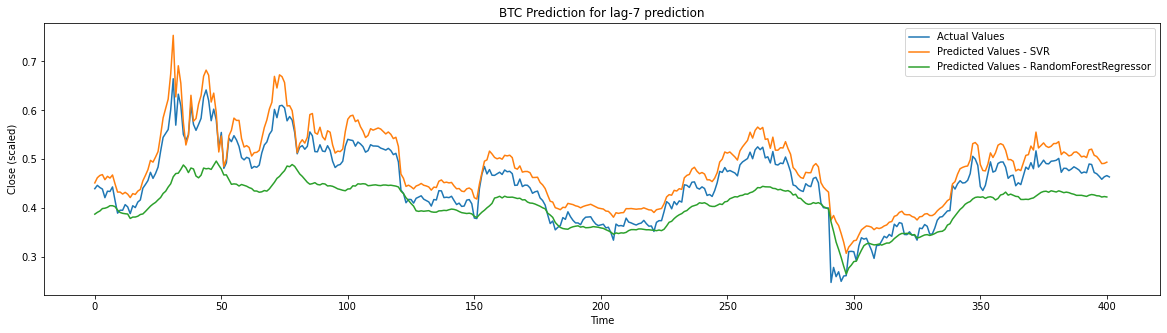

In [65]:
plt.figure(figsize=(20,5))
plt.plot(data1_scaled.Close.values[int(0.8*len(data1_scaled.Close.values)):])
plt.plot(models_trained[0].predict(X1_test))
plt.plot(models_trained[1].predict(X1_test))
plt.legend(['Actual Values', 'Predicted Values - SVR', 'Predicted Values - RandomForestRegressor'])
plt.title('BTC Prediction for lag-7 prediction')
plt.xlabel('Time')
plt.ylabel('Close (scaled)')
plt.show()

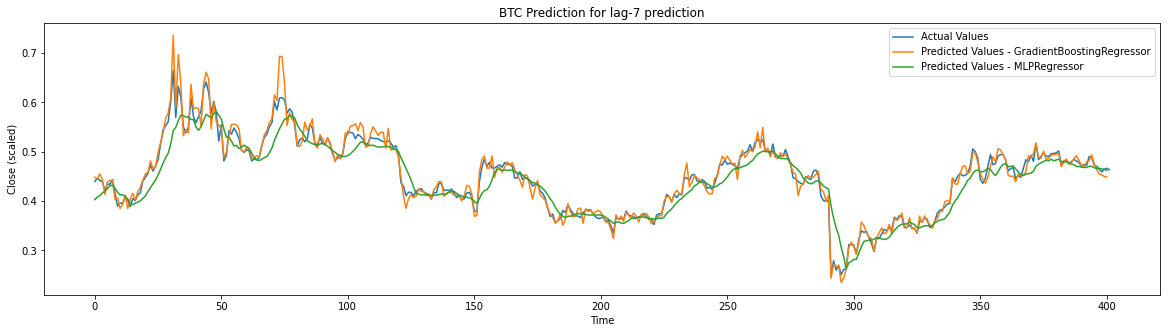

In [66]:
plt.figure(figsize=(20,5))
plt.plot(data1_scaled.Close.values[int(0.8*len(data1_scaled.Close.values)):])
plt.plot(models_trained[2].predict(X1_test))
plt.plot(models_trained[3].predict(X1_test))
plt.legend(['Actual Values', 'Predicted Values - GradientBoostingRegressor', 'Predicted Values - MLPRegressor'])
plt.title('BTC Prediction for lag-7 prediction')
plt.xlabel('Time')
plt.ylabel('Close (scaled)')
plt.show()

#### Data2

In [67]:
models_used = [
    SVR(kernel='rbf', C=10),
    RandomForestRegressor(criterion='squared_error', n_estimators=500, max_depth=10, max_samples=12, max_leaf_nodes = 150),
    GradientBoostingRegressor(loss='squared_error', n_estimators=400, max_depth=5, max_leaf_nodes = 15, learning_rate = 0.1),
     MLPRegressor((14,), activation='logistic', learning_rate='adaptive', max_iter=500)
]

In [68]:
models_trained = []
scores = []
for model in tqdm.tqdm(models_used):
    model.fit(X2_train, y2_train.reshape(-1,1))
    y_predicted = model.predict(X2_train).reshape(-1,1)
    y_actual = y2_train
    
    rmse1 = sqrt(mean_squared_error(y_actual, y_predicted))
    mape1 = mean_absolute_percentage_error(y_actual, y_predicted)

    
    y_predicted = model.predict(X2_test).reshape(-1,1)
    y_actual = y2_test
    
    rms = sqrt(mean_squared_error(y_actual, y_predicted))
    map_ = mean_absolute_percentage_error(y_actual, y_predicted)

    models_trained.append(model)
    model_name = type(model).__name__
    scores.append((model_name,(f'{rmse1:.4f}'), (f'{rms:.2f}'), (f'{mape1:.4f}%'), (f'{map_:.4f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Training RMSE', 'Testing RMSE', 'Training MAPE', 'Testing MAPE'])

100%|██████████| 4/4 [00:02<00:00,  1.97it/s]


In [69]:
scores_df

,Classifier,Training RMSE,Testing RMSE,Training MAPE,Testing MAPE
0,SVR,0.0540,0.05,242.5147%,86.9706%
1,RandomForestRegressor,0.0521,0.01,61.3592%,14.3576%
2,GradientBoostingRegressor,0.0012,0.01,1.5810%,8.7132%
3,MLPRegressor,0.0522,0.03,105.1532%,42.0460%


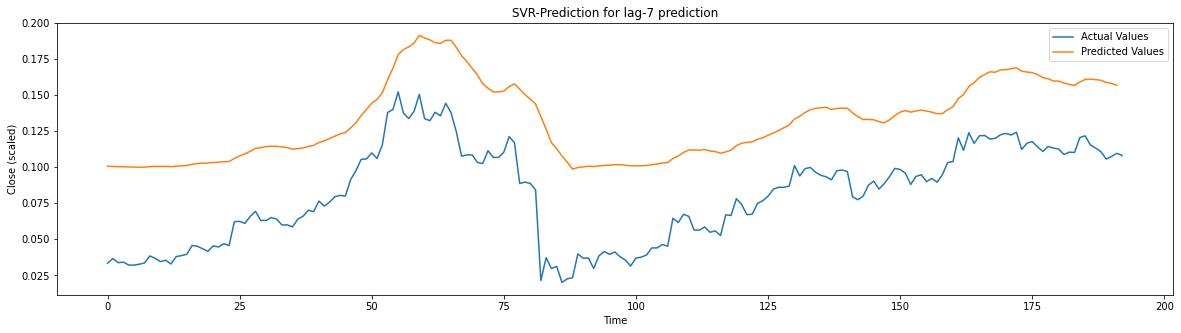

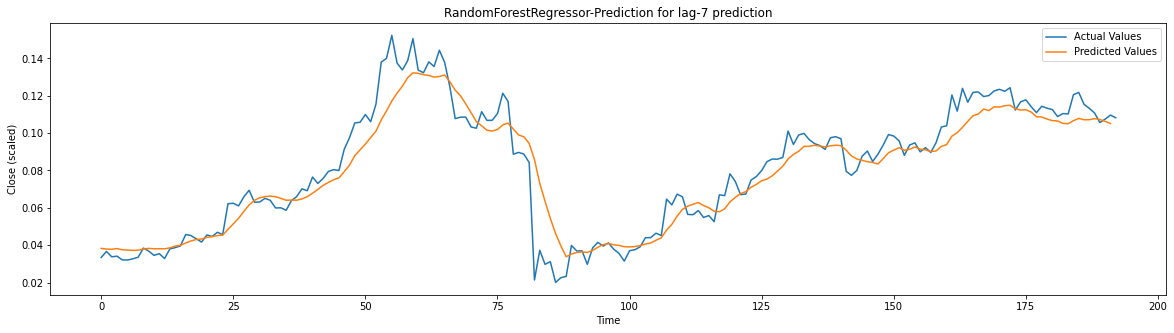

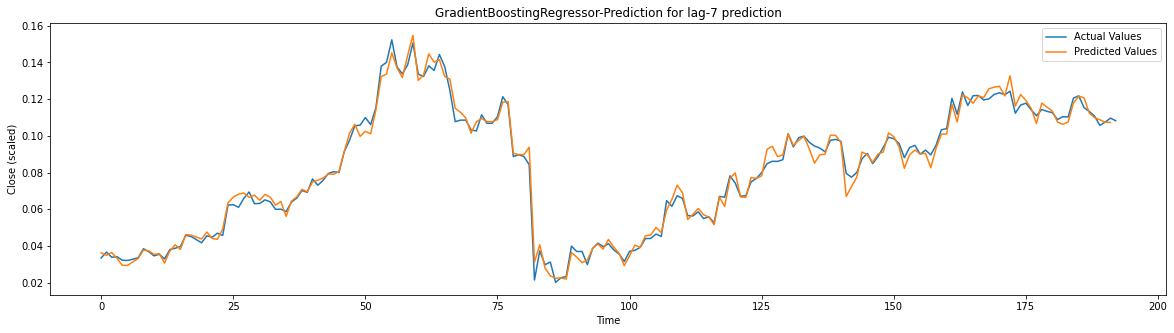

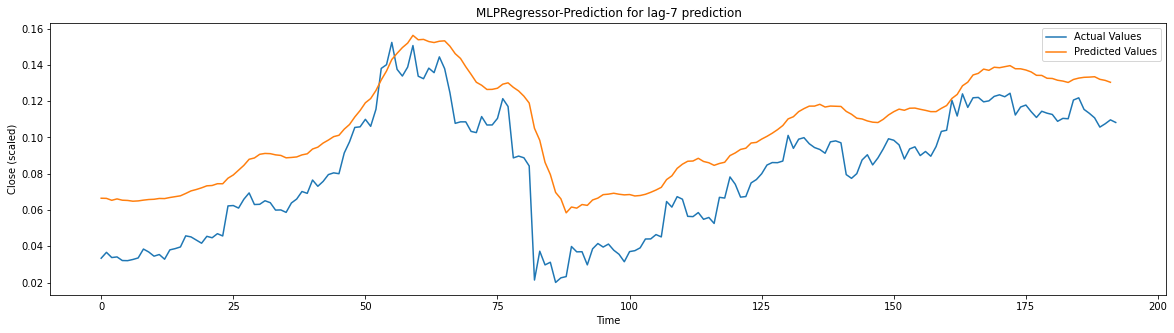

In [70]:
for i in models_trained:
    plt.figure(figsize=(20,5))
    plt.plot(data2_scaled.Close.values[int(0.8*len(data2_scaled.Close.values)):])
    plt.plot(i.predict(X2_test))
    plt.legend(['Actual Values', 'Predicted Values'])
    plt.title(f'{type(i).__name__}-Prediction for lag-7 prediction')
    plt.xlabel('Time')
    plt.ylabel('Close (scaled)')
    plt.show()

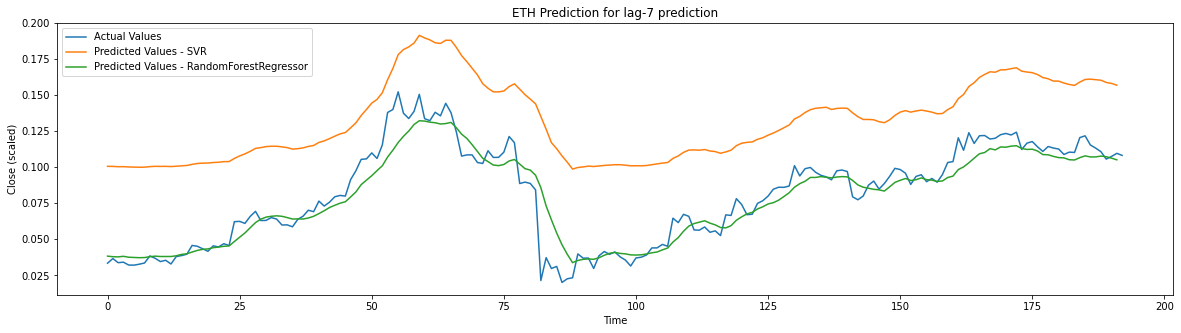

In [71]:
plt.figure(figsize=(20,5))
plt.plot(data2_scaled.Close.values[int(0.8*len(data2_scaled.Close.values)):])
plt.plot(models_trained[0].predict(X2_test))
plt.plot(models_trained[1].predict(X2_test))
plt.legend(['Actual Values', 'Predicted Values - SVR', 'Predicted Values - RandomForestRegressor'])
plt.title('ETH Prediction for lag-7 prediction')
plt.xlabel('Time')
plt.ylabel('Close (scaled)')
plt.show()

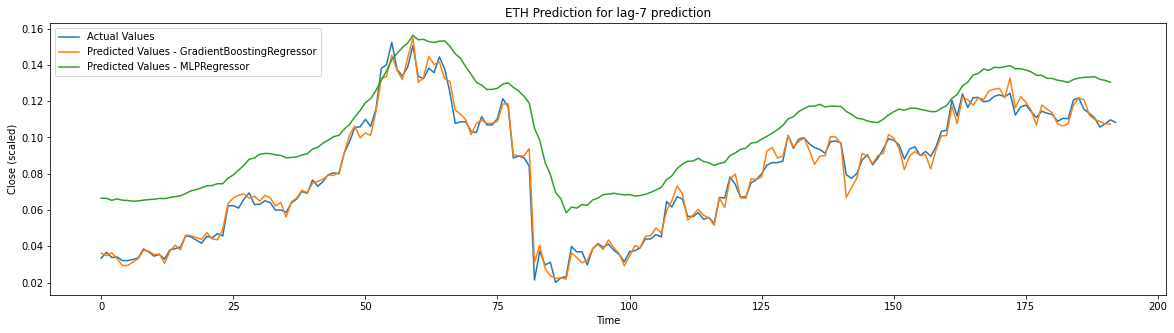

In [72]:
plt.figure(figsize=(20,5))
plt.plot(data2_scaled.Close.values[int(0.8*len(data2_scaled.Close.values)):])
plt.plot(models_trained[2].predict(X2_test))
plt.plot(models_trained[3].predict(X2_test))
plt.legend(['Actual Values', 'Predicted Values - GradientBoostingRegressor', 'Predicted Values - MLPRegressor'])
plt.title('ETH Prediction for lag-7 prediction')
plt.xlabel('Time')
plt.ylabel('Close (scaled)')
plt.show()

## End